In [0]:
import time
import torch
import zipfile
import collections
from torch import nn

In [0]:
!wget http://www.manythings.org/anki/fra-eng.zip

--2020-01-06 10:23:46--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:30::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5800008 (5.5M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   5.53M  3.37MB/s    in 1.6s    

2020-01-06 10:23:48 (3.37 MB/s) - ‘fra-eng.zip’ saved [5800008/5800008]



In [0]:
with zipfile.ZipFile("fra-eng.zip", 'r') as f:
    raw_text = f.read('fra.txt').decode("utf-8")
print(raw_text[0:95])

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
Hi.	Sa


In [0]:
def preprocess_raw(text):
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    out = ''
    for i, char in enumerate(text.lower()):
        if char in (',', '!', '.') and i > 0 and text[i-1] != ' ':
            out += ' '
        out += char
    return out

text = preprocess_raw(raw_text)
print(text[0:95])

go .	va !	cc-by 2 .0 (france) attribution: tatoeba .org #2877272 (cm) & #1158250 (wittydev)
hi 


In [0]:
text[:200]

'go .\tva !\tcc-by 2 .0 (france) attribution: tatoeba .org #2877272 (cm) & #1158250 (wittydev)\nhi .\tsalut !\tcc-by 2 .0 (france) attribution: tatoeba .org #538123 (cm) & #509819 (aiji)\nhi .\tsalut .\tcc-by '

In [0]:
num_examples = 1000
source, target = [], []
for i, line in enumerate(text.split('\n')):
    if i > num_examples:
        break
    parts = line.split('\t')
    if len(parts) == 3:
        source.append(parts[0].split(' '))
        target.append(parts[1].split(' '))

source[0:3], target[0:3]

([['go', '.'], ['hi', '.'], ['hi', '.']],
 [['va', '!'], ['salut', '!'], ['salut', '.']])

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

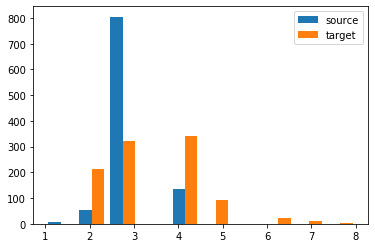

In [0]:
plt.hist([[len(l) for l in source], [len(l) for l in target]],
             label=['source', 'target'])
plt.legend(loc='upper right')
plt.show()

In [0]:
class Vocab(object):
    def __init__(self, tokens, min_freq=0, use_special_tokens=False):
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[0])
        self.token_freqs.sort(key=lambda x: x[1], reverse=True)
        if use_special_tokens:
            self.pad, self.bos, self.eos, self.unk = (0, 1, 2, 3)
            uniq_tokens = ['<pad>', '<bos>', '<eos>', '<unk>']
        else:
            self.unk, uniq_tokens = 0, ['<unk>']
        uniq_tokens +=  [token for token, freq in self.token_freqs 
                         if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1
            
    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

In [0]:
def build_vocab(tokens):
    tokens = [token for line in tokens for token in line]
    return Vocab(tokens, min_freq=3, use_special_tokens=True)

src_vocab = build_vocab(source)
len(src_vocab)

178

In [0]:
def pad(line, max_len, padding_token):
    if len(line) > max_len:
        return line[:max_len]
    return line + [padding_token] * (max_len - len(line))

pad(src_vocab[source[0]], 10, src_vocab.pad)

[9, 4, 0, 0, 0, 0, 0, 0, 0, 0]

In [0]:
def build_array(lines, vocab, max_len, is_source, build_mask=False):
    lines = [vocab[line] for line in lines]
    if not is_source:
        lines = [[vocab.bos] + line + [vocab.eos] for line in lines]
    array = torch.LongTensor([pad(line, max_len, vocab.pad) for line in lines])
    valid_len = (array != vocab.pad).sum(axis=1)
    
    if build_mask:
        mask = torch.zeros_like(array).type(torch.float)
        for i in range(len(valid_len)):
            mask[i, :valid_len[i]]=1.
        return array, valid_len, mask

    return array, valid_len

In [0]:
def load_data_nmt(batch_size, max_len): 
    src_vocab, tgt_vocab = build_vocab(source), build_vocab(target)
    src_array, src_valid_len = build_array(source, src_vocab, max_len, True, False)
    tgt_array, tgt_valid_len, tgt_mask = build_array(target, tgt_vocab, max_len, False, True)
    train_data = torch.utils.data.TensorDataset(
        src_array, src_valid_len, tgt_array, tgt_valid_len, tgt_mask)
    train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
    return src_vocab, tgt_vocab, train_iter

In [0]:
src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size=2, max_len=8)
for X, X_valid_len, Y, Y_valid_len, y_mask in train_iter:
    print('X =', X.type(torch.int), '\nValid lengths for X =', X_valid_len,
          '\nY =', Y.type(torch.int), '\nValid lengths for Y =', Y_valid_len,
          '\nY mask =', y_mask)
    break

X = tensor([[13, 27,  8,  4,  0,  0,  0,  0],
        [ 7,  3,  4,  0,  0,  0,  0,  0]], dtype=torch.int32) 
Valid lengths for X = tensor([4, 3]) 
Y = tensor([[  1,  10, 101, 159,   4,   2,   0,   0],
        [  1,   6,   7,   3,   4,   2,   0,   0]], dtype=torch.int32) 
Valid lengths for Y = tensor([6, 6]) 
Y mask = tensor([[1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.]])


In [0]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers

    def forward(self, X, *args):
        X = self.embedding(X) 
        X = X.permute(1, 0, 2)
        state = (torch.zeros((self.num_layers, X.shape[1],self.num_hiddens)), torch.zeros((self.num_layers, X.shape[1],self.num_hiddens)))
        out, state = self.rnn(X, state)
        return out, state

In [0]:
encoder = Encoder(vocab_size=10, embed_size=8,
                         num_hiddens=16, num_layers=2)
X = torch.zeros((4, 7)).type(torch.long)
output, state = encoder(X)
output.shape, len(state), state[0].shape, state[1].shape

(torch.Size([7, 4, 16]), 2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

In [0]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        self.num_hiddens = num_hiddens
        self.embed_size = embed_size
        self.vocab_size = vocab_size

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        out, state = self.rnn(X, state)
        out = self.dense(out.view(-1, self.num_hiddens)).view(out.shape[0], out.shape[1], self.vocab_size).permute(1, 0, 2)
        return out, state

In [0]:
decoder = Decoder(vocab_size=10, embed_size=8,
                         num_hiddens=16, num_layers=2)
state = decoder.init_state(encoder(X))
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, state[1].shape

(torch.Size([4, 7, 10]), 2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

In [0]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

In [0]:
def train(model, data_iter, lr, num_epochs, out_vocab_size):
    trainer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss(reduction='none')
    tic = time.time()
    for epoch in range(1, num_epochs+1):
        l_sum, num_tokens_sum = 0.0, 0.0
        for batch in data_iter:
            trainer.zero_grad()
            X, X_vlen, Y, Y_vlen, mask = [x for x in batch]
            Y_input, Y_label, Y_vlen, mask = Y[:,:-1], Y[:,1:], Y_vlen-1, mask[:,1:]
            Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
            
            
            l = (loss(Y_hat.reshape(-1,out_vocab_size), Y_label.reshape(-1)) * mask.reshape(-1)).sum() 
            
            
            l.backward()
            num_tokens = Y_vlen.sum().item()
            trainer.step()
            l_sum += l.item()
            num_tokens_sum += num_tokens

        print("epoch %d, loss %.3f, time %.1f sec" % (
            epoch, l_sum/num_tokens_sum, time.time()-tic))
        tic = time.time()

In [0]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, max_len = 64, 10
lr, num_epochs = 0.0001, 300

src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size, max_len)
encoder = Encoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Decoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = EncoderDecoder(encoder, decoder)
train(model, train_iter, lr, num_epochs, len(tgt_vocab))

epoch 1, loss 5.094, time 0.5 sec
epoch 2, loss 5.077, time 0.4 sec
epoch 3, loss 5.059, time 0.4 sec
epoch 4, loss 5.038, time 0.4 sec
epoch 5, loss 5.013, time 0.4 sec
epoch 6, loss 4.979, time 0.4 sec
epoch 7, loss 4.933, time 0.4 sec
epoch 8, loss 4.868, time 0.4 sec
epoch 9, loss 4.780, time 0.4 sec
epoch 10, loss 4.663, time 0.4 sec
epoch 11, loss 4.523, time 0.4 sec
epoch 12, loss 4.368, time 0.4 sec
epoch 13, loss 4.211, time 0.4 sec
epoch 14, loss 4.058, time 0.4 sec
epoch 15, loss 3.918, time 0.4 sec
epoch 16, loss 3.791, time 0.4 sec
epoch 17, loss 3.679, time 0.4 sec
epoch 18, loss 3.579, time 0.4 sec
epoch 19, loss 3.492, time 0.4 sec
epoch 20, loss 3.416, time 0.4 sec
epoch 21, loss 3.349, time 0.4 sec
epoch 22, loss 3.291, time 0.4 sec
epoch 23, loss 3.239, time 0.4 sec
epoch 24, loss 3.195, time 0.4 sec
epoch 25, loss 3.155, time 0.4 sec
epoch 26, loss 3.121, time 0.4 sec
epoch 27, loss 3.089, time 0.4 sec
epoch 28, loss 3.061, time 0.4 sec
epoch 29, loss 3.036, time 0.

In [0]:
def translate(model, src_sentence, src_vocab, tgt_vocab, max_len):
    src_tokens = src_vocab[src_sentence.lower().split(' ')]
    src_len = len(src_tokens)
    if src_len < max_len:
        src_tokens += [src_vocab.pad] * (max_len - src_len)
    enc_X = torch.LongTensor(src_tokens)
    enc_valid_length = torch.LongTensor([src_len])
    enc_outputs = model.encoder(enc_X.unsqueeze(axis=0), enc_valid_length)
    dec_state = model.decoder.init_state(enc_outputs, enc_valid_length)
    dec_X = torch.LongTensor([tgt_vocab.bos]).unsqueeze(axis=0)
    predict_tokens = []
    for _ in range(max_len):
        Y, dec_state = model.decoder(dec_X, dec_state)
        dec_X = Y.argmax(axis=2)
        py = dec_X.squeeze(axis=0).type(torch.long).item()
        if py == tgt_vocab.eos:
            break
        predict_tokens.append(py)
    return ' '.join(tgt_vocab.to_tokens(predict_tokens))

In [0]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + translate(
        model, sentence, src_vocab, tgt_vocab, max_len))

Go . => <unk> !
Wow ! => <unk> !
I'm OK . => je suis <unk> .
I won ! => je <unk> .


In [0]:
train(model, train_iter, lr, num_epochs, len(tgt_vocab))

epoch 1, loss 1.678, time 0.4 sec
epoch 2, loss 1.674, time 0.4 sec
epoch 3, loss 1.673, time 0.4 sec
epoch 4, loss 1.670, time 0.4 sec
epoch 5, loss 1.667, time 0.4 sec
epoch 6, loss 1.664, time 0.4 sec
epoch 7, loss 1.662, time 0.4 sec
epoch 8, loss 1.659, time 0.4 sec
epoch 9, loss 1.656, time 0.4 sec
epoch 10, loss 1.655, time 0.4 sec
epoch 11, loss 1.652, time 0.4 sec
epoch 12, loss 1.650, time 0.4 sec
epoch 13, loss 1.647, time 0.4 sec
epoch 14, loss 1.645, time 0.4 sec
epoch 15, loss 1.642, time 0.4 sec
epoch 16, loss 1.640, time 0.4 sec
epoch 17, loss 1.637, time 0.4 sec
epoch 18, loss 1.635, time 0.4 sec
epoch 19, loss 1.633, time 0.4 sec
epoch 20, loss 1.630, time 0.4 sec
epoch 21, loss 1.628, time 0.4 sec
epoch 22, loss 1.626, time 0.4 sec
epoch 23, loss 1.624, time 0.4 sec
epoch 24, loss 1.621, time 0.4 sec
epoch 25, loss 1.619, time 0.4 sec
epoch 26, loss 1.617, time 0.4 sec
epoch 27, loss 1.615, time 0.4 sec
epoch 28, loss 1.613, time 0.4 sec
epoch 29, loss 1.610, time 0.

In [0]:
train(model, train_iter, lr / 10, num_epochs, len(tgt_vocab))

epoch 1, loss 1.177, time 0.4 sec
epoch 2, loss 1.176, time 0.4 sec
epoch 3, loss 1.176, time 0.4 sec
epoch 4, loss 1.176, time 0.4 sec
epoch 5, loss 1.176, time 0.4 sec
epoch 6, loss 1.175, time 0.4 sec
epoch 7, loss 1.175, time 0.4 sec
epoch 8, loss 1.175, time 0.4 sec
epoch 9, loss 1.175, time 0.4 sec
epoch 10, loss 1.175, time 0.4 sec
epoch 11, loss 1.175, time 0.4 sec
epoch 12, loss 1.175, time 0.4 sec
epoch 13, loss 1.175, time 0.4 sec
epoch 14, loss 1.174, time 0.4 sec
epoch 15, loss 1.174, time 0.4 sec
epoch 16, loss 1.174, time 0.4 sec
epoch 17, loss 1.174, time 0.4 sec
epoch 18, loss 1.174, time 0.4 sec
epoch 19, loss 1.174, time 0.4 sec
epoch 20, loss 1.174, time 0.4 sec
epoch 21, loss 1.174, time 0.4 sec
epoch 22, loss 1.174, time 0.4 sec
epoch 23, loss 1.173, time 0.4 sec
epoch 24, loss 1.173, time 0.4 sec
epoch 25, loss 1.173, time 0.4 sec
epoch 26, loss 1.173, time 0.4 sec
epoch 27, loss 1.173, time 0.4 sec
epoch 28, loss 1.173, time 0.4 sec
epoch 29, loss 1.173, time 0.

In [0]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + translate(
        model, sentence, src_vocab, tgt_vocab, max_len))

Go . => <unk> !
Wow ! => <unk> !
I'm OK . => je suis <unk> .
I won ! => je suis <unk> .


# Homework

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "" # username from the json file
os.environ['KAGGLE_KEY'] = "" # key from the json file

In [2]:
!kaggle competitions download -c twitter-sentiment-analysis2

 46% 5.00M/11.0M [00:00<00:00, 20.8MB/s]
100% 11.0M/11.0M [00:00<00:00, 36.5MB/s]
  0% 0.00/3.67M [00:00<?, ?B/s]
100% 3.67M/3.67M [00:00<00:00, 215MB/s]


In [3]:
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [4]:
!head -n 10 train.csv

ItemID,Sentiment,SentimentText
1,0,                     is so sad for my APL friend.............
2,0,                   I missed the New Moon trailer...
3,1,              omg its already 7:30 :O
4,0,          .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...
5,0,         i think mi bf is cheating on me!!!       T_T
6,0,         or i just worry too much?        
7,1,       Juuuuuuuuuuuuuuuuussssst Chillin!!
8,0,       Sunny Again        Work Tomorrow  :-|       TV Tonight
9,1,      handed in my uniform today . i miss you already


In [5]:
import pandas as pd
import pprint
print('Train dataset')
df_train = pd.read_csv('train.csv',encoding='latin')
pprint.pprint(df_train.head())
print('\nTest dataset')
df_test = pd.read_csv('test.csv',encoding='latin')
pprint.pprint(df_test.head())
#0 - negative
#1 - positive

Train dataset
   ItemID  Sentiment                                      SentimentText
0       1          0                       is so sad for my APL frie...
1       2          0                     I missed the New Moon trail...
2       3          1                            omg its already 7:30 :O
3       4          0            .. Omgaga. Im sooo  im gunna CRy. I'...
4       5          0           i think mi bf is cheating on me!!!   ...

Test dataset
   ItemID                                      SentimentText
0       1                       is so sad for my APL frie...
1       2                     I missed the New Moon trail...
2       3                            omg its already 7:30 :O
3       4            .. Omgaga. Im sooo  im gunna CRy. I'...
4       5           i think mi bf is cheating on me!!!   ...


In [0]:
from gensim.models import Word2Vec
import re
df_train['SentimentTextNew'] = df_train['SentimentText'].apply(lambda s: [re.sub('&quot','',re.sub(r'[\,\./?]', '', x)) for x in s.split() if not (x.startswith('@') or x.startswith('http') or ('@' in x))])
df_test['SentimentTextNew'] = df_test['SentimentText'].apply(lambda s: [re.sub('&quot','',re.sub(r'[\,\./?]', '', x)) for x in s.split() if not (x.startswith('@') or x.startswith('http') or ('@' in x))])

df_train['len'] = df_train['SentimentTextNew'].apply(lambda x: len(x))
df_train = df_train[df_train['len']>0]

df_test['len'] = df_test['SentimentTextNew'].apply(lambda x: len(x))
df_test = df_test[df_test['len']>0]

In [7]:
# train model
#model = Word2Vec(pd.concat([df_train[['ItemID','SentimentTextNew']],df_test[['ItemID','SentimentTextNew']]])['SentimentTextNew'].tolist(), min_count=1)
model = Word2Vec(df_train['SentimentTextNew'].tolist()+['unknown'], min_count=1)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words)
X = model[model.wv.vocab]

Word2Vec(vocab=101535, size=100, alpha=0.025)
['is', 'so', 'sad', 'for', 'my', 'APL', 'friend', 'I', 'missed', 'the', 'New', 'Moon', 'trailer', 'omg', 'its', 'already', '7:30', ':O', '', 'Omgaga', 'Im', 'sooo', 'im', 'gunna', 'CRy', "I've", 'been', 'at', 'this', 'dentist', 'since', '11', 'was', 'suposed', '2', 'just', 'get', 'a', 'crown', 'put', 'on', '(30mins)', 'i', 'think', 'mi', 'bf', 'cheating', 'me!!!', 'T_T', 'or', 'worry', 'too', 'much', 'Juuuuuuuuuuuuuuuuussssst', 'Chillin!!', 'Sunny', 'Again', 'Work', 'Tomorrow', ':-|', 'TV', 'Tonight', 'handed', 'in', 'uniform', 'today', 'miss', 'you', 'hmmmm', 'wonder', 'how', 'she', 'number', 'must', 'about', 'positive', 'thanks', 'to', 'all', 'haters', 'up', 'face', 'day!', '112-102', 'weekend', 'has', 'sucked', 'far', 'jb', 'isnt', 'showing', 'australia', 'any', 'more!', 'ok', 'thats', 'it', 'win', '&lt;--------', 'This', 'way', 'feel', 'right', 'now', 'awhhe', 'man', "I'm", 'completely', 'useless', 'rt', 'Funny', 'can', 'do', 'twitter',

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [8]:
X = [model[w] for w in df_train['SentimentTextNew'].tolist()]
y = df_train['Sentiment'].tolist()

MAX_LEN = 20
BATCH_SIZE = 8

import numpy as np
import torch
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

train_data = torch.zeros((len(X_train), MAX_LEN), dtype=int)
valid_data = torch.zeros((len(X_valid), MAX_LEN), dtype=int)

for i in range(len(X_train)):
  for j, w in enumerate(X_train[i]):
    if j >= MAX_LEN:
      break
    train_data[i, j] = torch.tensor(np.argmax(w))
for i in range(len(X_valid)):
  for j, w in enumerate(X_valid[i]):
    if j >= MAX_LEN:
      break
    valid_data[i, j] = torch.tensor(np.argmax(w))

train_dataset = torch.utils.data.TensorDataset(train_data, torch.LongTensor(y_train))
valid_dataset = torch.utils.data.TensorDataset(valid_data, torch.LongTensor(y_valid))
train = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
valid = torch.utils.data.DataLoader(valid_dataset, BATCH_SIZE, shuffle=False)
dev = torch.device('cuda')
print(dev)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


cuda


In [0]:
from torch import nn
import time

In [0]:
def validate_acc(model, dataset, dev):
  loss = nn.CrossEntropyLoss(reduction='sum')
  loss_acc, passed, correct = 0., 0, 0
  for X, y in dataset:
    X = X.to(dev)
    y = y.to(dev)

    output = model(X)
    l = loss(output, y)

    loss_acc += l.item()
    correct += (output.argmax(dim=1) == y).sum().item()
    passed += len(y)

  return loss_acc / passed, correct / passed

def train_model(model, train_dl, test_dl, trainer, dev, num_epochs=25):
  loss = nn.CrossEntropyLoss(reduction='sum')
  for ep in range(num_epochs):
    ep_start, tloss_acc, tpassed, tcorrect = time.time(), 0., 0, 0
    for X, y in train_dl:
      X, y = X.to(dev), y.to(dev)
      trainer.zero_grad()

      output = model(X)
      l = loss(output, y)
      l.backward()
      trainer.step()

      tloss_acc += l.item()
      tcorrect += (output.argmax(dim=1) == y).sum().item()
      tpassed += len(y)
      del X, y
    
    test_loss, test_acc = validate_acc(model, test_dl, dev)

    print('Epoch {}. Taked {:.3f} sec. Train loss: {:.3f}, Train acc {:.3f}, Valid  Loss {:.3f}, Valid Acc {:.3f}'.format(
        ep, time.time() - ep_start, tloss_acc / tpassed, tcorrect / tpassed, test_loss, test_acc
    ))

class UberModel(nn.Module):
  def __init__(self, dict_size, embed_size, num_hiddens, num_classes):
    super().__init__()

    self.num_hiddens = num_hiddens
    self.embed = nn.Embedding(dict_size, embed_size)
    self.rnn = nn.RNN(embed_size, num_hiddens, batch_first=True, num_layers=10, bidirectional=True)
    self.hidden = nn.Linear(num_hiddens, num_classes)

  def forward(self, X):
    output = self.embed(X)
    y, s = self.rnn(output)
    h = self.hidden(s[0])
    return h

In [11]:
torch_model = UberModel(len(words), 150, 128, 2).to(dev)
trainer = torch.optim.SGD(torch_model.parameters(), lr=0.0001)
train_model(torch_model, train, valid, trainer, dev, num_epochs=7)

Epoch 0. Taked 201.087 sec. Train loss: 0.684, Train acc 0.567, Valid  Loss 0.685, Valid Acc 0.572
Epoch 1. Taked 201.561 sec. Train loss: 0.683, Train acc 0.570, Valid  Loss 0.684, Valid Acc 0.570
Epoch 2. Taked 201.312 sec. Train loss: 0.682, Train acc 0.571, Valid  Loss 0.683, Valid Acc 0.571
Epoch 3. Taked 200.959 sec. Train loss: 0.682, Train acc 0.571, Valid  Loss 0.682, Valid Acc 0.571
Epoch 4. Taked 200.329 sec. Train loss: 0.682, Train acc 0.571, Valid  Loss 0.681, Valid Acc 0.571
Epoch 5. Taked 199.831 sec. Train loss: 0.682, Train acc 0.572, Valid  Loss 0.684, Valid Acc 0.573
Epoch 6. Taked 198.529 sec. Train loss: 0.682, Train acc 0.573, Valid  Loss 0.681, Valid Acc 0.574


### Check the accuracy with GRU instead of bidirectional multilayer RNN

In [12]:
class UberModel(nn.Module):
  def __init__(self, dict_size, embed_size, num_hiddens, num_classes):
    super().__init__()

    self.num_hiddens = num_hiddens
    self.embed = nn.Embedding(dict_size, embed_size)
    self.rnn = nn.GRU(embed_size, num_hiddens, batch_first=True, num_layers=2)
    self.hidden = nn.Linear(num_hiddens, num_classes)

  def forward(self, X):
    output = self.embed(X)
    y, s = self.rnn(output)
    h = self.hidden(s[0])
    return h

torch_model2 = UberModel(len(words), 150, 128, 2).to(dev)
trainer = torch.optim.SGD(torch_model.parameters(), lr=0.0001)
train_model(torch_model2, train, valid, trainer, dev, num_epochs=7)

Epoch 0. Taked 53.278 sec. Train loss: 0.688, Train acc 0.559, Valid  Loss 0.687, Valid Acc 0.564
Epoch 1. Taked 52.874 sec. Train loss: 0.688, Train acc 0.559, Valid  Loss 0.687, Valid Acc 0.564
Epoch 2. Taked 53.072 sec. Train loss: 0.688, Train acc 0.559, Valid  Loss 0.687, Valid Acc 0.564
Epoch 3. Taked 53.155 sec. Train loss: 0.688, Train acc 0.559, Valid  Loss 0.687, Valid Acc 0.564
Epoch 4. Taked 53.065 sec. Train loss: 0.688, Train acc 0.559, Valid  Loss 0.687, Valid Acc 0.564
Epoch 5. Taked 53.105 sec. Train loss: 0.688, Train acc 0.559, Valid  Loss 0.687, Valid Acc 0.564
Epoch 6. Taked 53.255 sec. Train loss: 0.688, Train acc 0.559, Valid  Loss 0.687, Valid Acc 0.564


# Get the predictions

In [13]:
X_test = [[model[x if x in words else 'unknown'] for x in w] for w in df_test['SentimentTextNew'].tolist()]
y_test = torch.zeros(len(X_test), dtype=int)
test_data = torch.zeros((len(X_test), MAX_LEN), dtype=int)

for i in range(len(X_test)):
  for j, w in enumerate(X_test[i]):
    if j >= MAX_LEN:
      break
    test_data[i, j] = torch.tensor(np.argmax(w))

test_dataset = torch.utils.data.TensorDataset(test_data, torch.LongTensor(y_test))
test = torch.utils.data.DataLoader(test_dataset, BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [14]:
len(X_test), len(X_train), len(X_test[0]), len(X_train[0])

(299049, 79746, 7, 2)

In [15]:
def predict(model, dataset, dev):
  predicted = []
  for X, _ in dataset:
    output = [t.flatten()[0] for t in [i.cpu().argmax(axis=0).numpy() for i in torch_model(X.to(dev))]]
    del X
    for o in output:
      predicted.append(o)
    #break
  return predicted

prediction = predict(torch_model, test, dev)
print(prediction)

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [0]:
df_test['class'] = prediction

In [17]:
df_train.head()

,ItemID,Sentiment,SentimentText,SentimentTextNew,len
0,1,0,is so sad for my APL frie...,"[is, so, sad, for, my, APL, friend]",7
1,2,0,I missed the New Moon trail...,"[I, missed, the, New, Moon, trailer]",6
2,3,1,omg its already 7:30 :O,"[omg, its, already, 7:30, :O]",5
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...,"[, Omgaga, Im, sooo, im, gunna, CRy, I've, bee...",25
4,5,0,i think mi bf is cheating on me!!! ...,"[i, think, mi, bf, is, cheating, on, me!!!, T_T]",9


In [18]:
df_test.head()

,ItemID,SentimentText,SentimentTextNew,len,class
0,1,is so sad for my APL frie...,"[is, so, sad, for, my, APL, friend]",7,1
1,2,I missed the New Moon trail...,"[I, missed, the, New, Moon, trailer]",6,1
2,3,omg its already 7:30 :O,"[omg, its, already, 7:30, :O]",5,1
3,4,.. Omgaga. Im sooo im gunna CRy. I'...,"[, Omgaga, Im, sooo, im, gunna, CRy, I've, bee...",25,0
4,5,i think mi bf is cheating on me!!! ...,"[i, think, mi, bf, is, cheating, on, me!!!, T_T]",9,1


In [19]:
!kaggle competitions submit -c twitter-sentiment-analysis2 -f submission.csv -m "Message"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/kaggle/cli.py", line 51, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 544, in competition_submit_cli
    competition, quiet)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 495, in competition_submit
    content_length=os.path.getsize(file_name),
  File "/usr/lib/python2.7/genericpath.py", line 57, in getsize
    return os.stat(filename).st_size
OSError: [Errno 2] No such file or directory: 'submission.csv'
